In [1]:
# Multi-turn Zero-shot ABSA on 
# 3.11.9

import pandas as pd
import numpy as np
import torch
from datasets import Dataset
import squarify
import matplotlib
import matplotlib.pyplot as plt
import os

In [2]:
from transformers import pipeline

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# pipeline for Zero-Shot Classification w NLI (NLI), better to identify keywords for candidate_labels
# nli1: facebook/bart-large-mnli -> # https://huggingface.co/facebook/bart-large-mnli?library=transformers
# nli2: MoritzLaurer/DeBERTa-v3-base-mnli-fever-anli -> # https://huggingface.co/MoritzLaurer/DeBERTa-v3-base-mnli-fever-anli?library=transformers
# nli3: cross-encoder/nli-roberta-base -> # https://huggingface.co/cross-encoder/nli-roberta-base?library=transformers

nli1 = pipeline("zero-shot-classification", model="facebook/bart-large-mnli", device=device)
nli2 = pipeline("zero-shot-classification", model="MoritzLaurer/DeBERTa-v3-base-mnli-fever-anli", device=device)
nli3 = pipeline("zero-shot-classification", model="cross-encoder/nli-roberta-base", device=device)


C:\Users\royle\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [3]:
df = pd.read_csv(r"combined_dfv4.csv")

# Define the aspect columns to check
aspect_columns = ['Price', 'Product Quality', 'Customer Service', 'Delivery']

# Filter the DataFrame
reviews = df[
    (df['Survey language'] == 'English') &
    (df['Month of Response Date'] == "Mar-24") &
    (~df[aspect_columns].isnull().all(axis=1))  # Check if not all aspect columns are null
][['Survey ID', 'Combined Text']]

len(reviews)

3817

In [10]:
from datasets import Dataset
import pandas as pd

# Select the NLI model to use
nli = nli1

# Define categories
cats = ['Price', 'Product Quality', 'Customer Service', 'Delivery']

# Prepare the dataset for efficient batch processing
reviews_dataset = Dataset.from_pandas(reviews[['Survey ID', 'Combined Text']])  # Create a Hugging Face Dataset with 'Survey ID' and 'Combined Text'

# Define a function to process each review and classify categories and sentiment
def process_review(batch):
    batch_results = []  # Store results for each batch
    
    for survey_id, s in zip(batch['Survey ID'], batch['Combined Text']):
        labels = []

        # Find applicable categories
        for c in cats:
            yes = f"It's a comment on {c}"
            no = f"It's not a comment on {c}"
            res = nli(s, candidate_labels=[yes, no])
            label = res['labels'][0]
            if res['scores'][0] >= 0.9 and "not" not in label:
                labels.append(c)

        # If no specific category is detected, assign "General"
        if not labels:
            labels.append('General')

        # Determine the polarity for each detected category (only positive or negative)
        review_results = []  # Temporary store for each sentence's result
        for l in labels:
            # Directly use 'positive' and 'negative' without creating additional strings
            res2 = nli(s, candidate_labels=['positive', 'neutral', 'negative'])
            polarity = res2['labels'][0]  # Directly get 'positive' or 'negative'
            
            review_results.append({
                "Survey ID": survey_id,  # Include Survey ID in the results
                "sentence": s,
                "cat": l,
                "polarity": polarity,  # Store polarity directly as 'positive' or 'negative'
                "polarity_score": res2['scores'][0]
            })
        
        # Append review_results for this sentence to batch_results
        batch_results.append(review_results)
    
    return {"results": batch_results}

# Apply the function to the dataset and process in batches
processed_results = reviews_dataset.map(lambda batch: process_review(batch), batched=True)

# Flatten the results list to avoid ArrowInvalid error (if each review has multiple labels)
flat_results = [item for sublist in processed_results["results"] for item in sublist]

# Convert the processed flattened results into a pandas DataFrame
df_results = pd.DataFrame(flat_results)
output_path = 'Multi-Turn Zero-Shot ABSA/nli1_df_results.csv'  # Replace 'your/path/here' with the actual file path
df_results.to_csv(output_path, index=False)

df_results.head(10)


Map:   0%|          | 0/10 [00:00<?, ? examples/s]

,Survey ID,cat,polarity,polarity_score,sentence
0,110020182,Instant Ink,positive,0.994894,"Excllent quality; easy to order, received prom..."
1,110020182,Quality,positive,0.994894,"Excllent quality; easy to order, received prom..."
2,110020182,Shipment,positive,0.994894,"Excllent quality; easy to order, received prom..."
3,123460320,General,positive,0.985882,Great price and arrived even earlier than stated.
4,133472112,Cost,positive,0.930847,"Price competitive with other sources, but deli..."
5,133472112,Quality,positive,0.930847,"Price competitive with other sources, but deli..."
6,133472112,Shipment,positive,0.930847,"Price competitive with other sources, but deli..."
7,134550233,General,negative,0.901488,Don't know. Never received my order
8,134626563,Quality,positive,0.928483,[This review was collected as part of a promot...
9,172491173,Instant Ink,positive,0.957588,I am so pleased with the supply of ink in this...


In [4]:
# Define the list of NLI models to use
nli_models = [nli1, nli2, nli3]
model_names = ['nli1_fbbart', 'nli2_msoftbert', 'nli3_roberta']

# Define categories
cats = ['Price', 'Product Quality', 'Customer Service', 'Delivery']

# Prepare the dataset for efficient batch processing
reviews_dataset = Dataset.from_pandas(reviews[['Survey ID', 'Combined Text']])  # Create a Hugging Face Dataset with 'Survey ID' and 'Combined Text'

# Define a function to process each review and classify categories and sentiment
def process_review(batch, nli):
    batch_results = []  # Store results for each batch
    
    for survey_id, s in zip(batch['Survey ID'], batch['Combined Text']):
        labels = []

        # Find applicable categories
        for c in cats:
            yes = f"It's a comment on {c}"
            no = f"It's not a comment on {c}"
            res = nli(s, candidate_labels=[yes, no])
            label = res['labels'][0]
            if res['scores'][0] >= 0.9 and "not" not in label:
                labels.append(c)

        # If no specific category is detected, assign "General"
        if not labels:
            labels.append('Others')

        # Determine the polarity for each detected category (only positive or negative)
        review_results = []  # Temporary store for each sentence's result
        for l in labels:
            # Directly use 'positive' and 'negative' without creating additional strings
            res2 = nli(s, candidate_labels=['positive', 'neutral', 'negative'])
            polarity = res2['labels'][0]  # Directly get 'positive' or 'negative'
            
            review_results.append({
                "Survey ID": survey_id,  # Include Survey ID in the results
                "sentence": s,
                "cat": l,
                "polarity": polarity,  # Store polarity directly as 'positive' or 'negative'
                "polarity_score": res2['scores'][0]
            })
        
        # Append review_results for this sentence to batch_results
        batch_results.append(review_results)
    
    return {"results": batch_results}

# Iterate through each NLI model and process the dataset
for nli, model_name in zip(nli_models, model_names):
    # Apply the function to the dataset and process in batches
    processed_results = reviews_dataset.map(lambda batch: process_review(batch, nli), batched=True)

    # Flatten the results list to avoid ArrowInvalid error (if each review has multiple labels)
    flat_results = [item for sublist in processed_results["results"] for item in sublist]

    # Convert the processed flattened results into a pandas DataFrame
    df_results = pd.DataFrame(flat_results)
    
    # Export to CSV
    output_path = f'Multi-Turn Zero-Shot ABSA/{model_name}_df_results.csv'  # Create file path dynamically
    df_results.to_csv(output_path, index=False)


Map:   0%|          | 0/3817 [00:00<?, ? examples/s]

C:\Users\royle\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\models\bart\modeling_bart.py:496: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Map:   0%|          | 0/3817 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/3817 [00:00<?, ? examples/s]

In [2]:
# Skip model training

# File paths for the three CSV files
file_paths = [r"Multi-Turn Zero-Shot ABSA\Mar-24\nli1_fbbart_df_results.csv", 
              r"Multi-Turn Zero-Shot ABSA\Mar-24\nli2_msoftbert_df_results.csv", 
              r"Multi-Turn Zero-Shot ABSA\Mar-24\nli3_roberta_df_results.csv"
              ]

# Set Pandas display options to avoid row wrapping
pd.set_option('display.max_columns', None)  # Display all columns
pd.set_option('display.expand_frame_repr', False)  # Prevent line breaks

# Loop through each file, process it individually, and display the result
for i, file in enumerate(file_paths, start=1):
    # Read each CSV file
    df_results = pd.read_csv(file)
    
    # Generate a summary table with cross-tabulation
    summary = pd.crosstab(df_results['cat'], df_results['polarity'])
    
    # Convert the summary into a DataFrame and add the category column
    df_summary = pd.DataFrame(summary)
    df_summary["category"] = df_summary.index
    
    # Handle missing columns for any missing sentiment labels
    for col in ['positive', 'negative']:
        if col not in df_summary.columns:
            df_summary[col] = 0
    
    # Calculate the total number of sentiments (positive + negative) per category
    df_summary["total p+n"] = df_summary["positive"] + df_summary["negative"]
    
    # Calculate the overall sentiment score for each category
    # Score: (positive - negative) / (positive + negative)
    df_summary["sentiment"] = np.round((df_summary["positive"] - df_summary["negative"]) / (df_summary["positive"] + df_summary["negative"]), 2)
    
    # Display the summary DataFrame for each file
    print(f"Summary for file {i} ({file}):")
    print(df_summary)
    print("\n" + "="*50 + "\n")


Summary for file 1 (Multi-Turn Zero-Shot ABSA\Mar-24\nli1_fbbart_df_results.csv):
polarity          negative  neutral  positive          category  total p+n  sentiment
cat                                                                                  
Customer Service       999        1       296  Customer Service       1295      -0.54
Delivery                99        0       138          Delivery        237       0.16
Others                 649       25       338            Others        987      -0.32
Price                  766        7       349             Price       1115      -0.37
Product Quality       1382        8       823   Product Quality       2205      -0.25


Summary for file 2 (Multi-Turn Zero-Shot ABSA\Mar-24\nli2_msoftbert_df_results.csv):
polarity          negative  neutral  positive          category  total p+n  sentiment
cat                                                                                  
Customer Service       693       26       391  Customer S

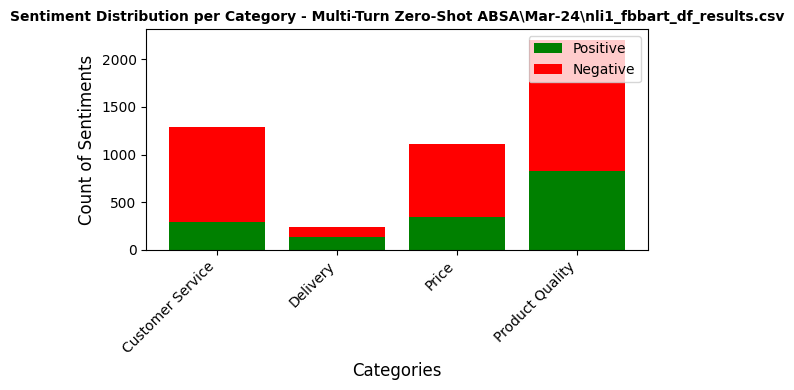

Summary for Multi-Turn Zero-Shot ABSA\Mar-24\nli1_fbbart_df_results.csv:
polarity          negative  neutral  positive          category  total p+n  sentiment
cat                                                                                  
Customer Service       999        1       296  Customer Service       1295      -0.54
Delivery                99        0       138          Delivery        237       0.16
Price                  766        7       349             Price       1115      -0.37
Product Quality       1382        8       823   Product Quality       2205      -0.25




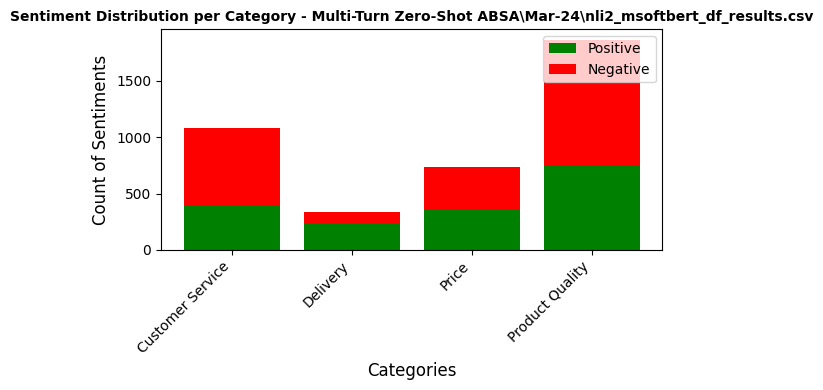

Summary for Multi-Turn Zero-Shot ABSA\Mar-24\nli2_msoftbert_df_results.csv:
polarity          negative  neutral  positive          category  total p+n  sentiment
cat                                                                                  
Customer Service       693       26       391  Customer Service       1084      -0.28
Delivery               111       14       228          Delivery        339       0.35
Price                  375       58       361             Price        736      -0.02
Product Quality       1108       35       756   Product Quality       1864      -0.19




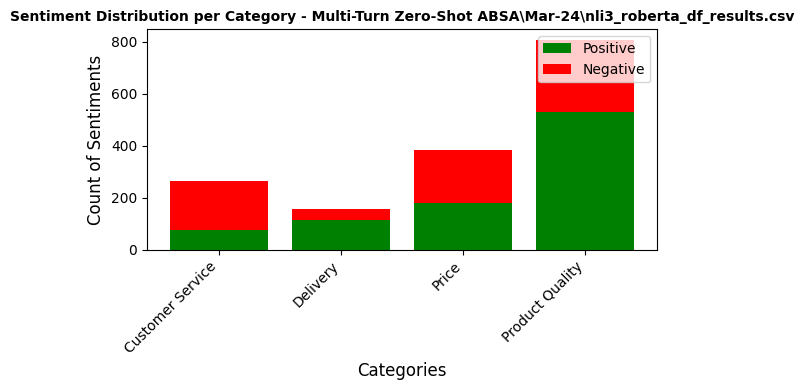

Summary for Multi-Turn Zero-Shot ABSA\Mar-24\nli3_roberta_df_results.csv:
polarity          negative  neutral  positive          category  total p+n  sentiment
cat                                                                                  
Customer Service       189        0        76  Customer Service        265      -0.43
Delivery                43        1       115          Delivery        158       0.46
Price                  203        0       182             Price        385      -0.05
Product Quality        277        0       531   Product Quality        808       0.31




In [4]:
# Loop through each file, process it individually, and display the result
for i, file in enumerate(file_paths, start=1):
    # Read each CSV file
    df_results = pd.read_csv(file)
    
    # Generate a summary table with cross-tabulation
    summary = pd.crosstab(df_results['cat'], df_results['polarity'])
    
    # Convert the summary into a DataFrame and add the category column
    df_summary = pd.DataFrame(summary)
    df_summary["category"] = df_summary.index

    # Omit records where category is 'Others'
    df_summary = df_summary[df_summary["category"] != 'Others']
    
    # Handle missing columns for any missing sentiment labels
    for col in ['positive', 'negative']:
        if col not in df_summary.columns:
            df_summary[col] = 0
    
    # Calculate the total number of sentiments (positive + negative) per category
    df_summary["total p+n"] = df_summary["positive"] + df_summary["negative"]
    
    # Calculate the overall sentiment score for each category
    # Score: (positive - negative) / (positive + negative)
    df_summary["sentiment"] = np.round((df_summary["positive"] - df_summary["negative"]) / (df_summary["positive"] + df_summary["negative"]), 2)
    
    # Plot stacked bar chart for each file
    categories = df_summary['category']
    positive = df_summary['positive']
    negative = df_summary['negative']
    
    fig, ax = plt.subplots(figsize=(6, 4))
    
    # Plot positive and negative sentiments as stacked bars
    ax.bar(categories, positive, label='Positive', color='green')
    ax.bar(categories, negative, bottom=positive, label='Negative', color='red')
    
    # Set chart title and labels
    ax.set_title(f"Sentiment Distribution per Category - {file}", fontsize=10, fontweight="bold")
    ax.set_xlabel('Categories', fontsize=12)
    ax.set_ylabel('Count of Sentiments', fontsize=12)
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha='right')
    
    # Add legend to distinguish positive and negative
    ax.legend(loc='upper right')
    
    plt.tight_layout()  # Adjust layout to make space for rotated labels
    plt.show()
    
    # Print summary for reference
    print(f"Summary for {file}:")
    print(df_summary)
    print("\n" + "="*50 + "\n")

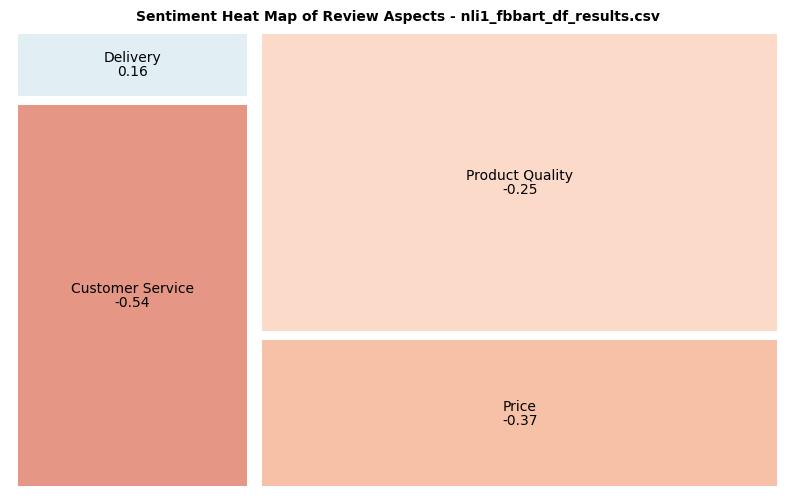

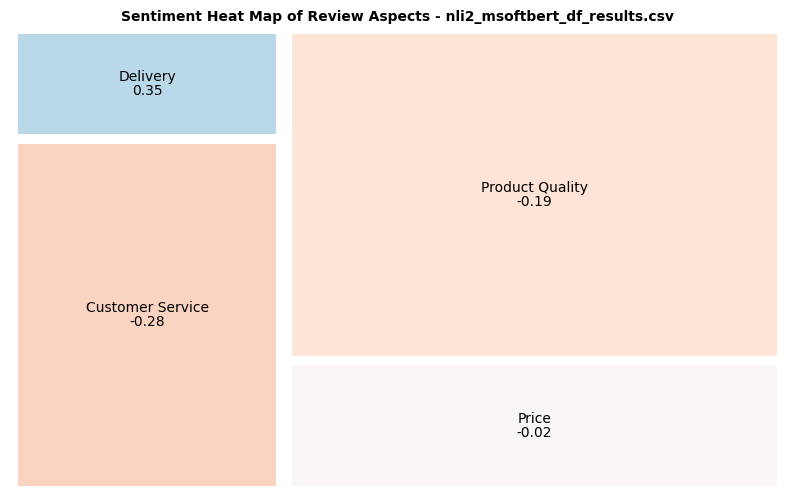

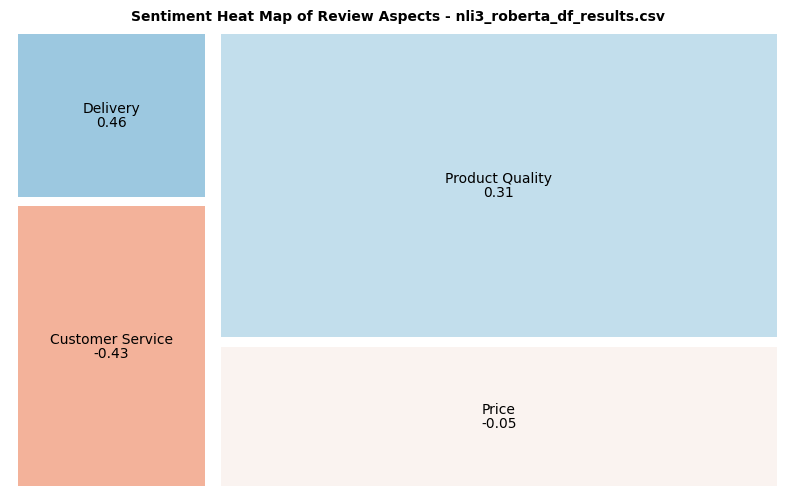

In [6]:
dfs = []

# Step 1: Read all files and calculate the global min/max for sentiment values
for file in file_paths:
    df_results = pd.read_csv(file)
    # Generate a summary table with cross-tabulation
    summary = pd.crosstab(df_results['cat'], df_results['polarity'])
    
    # Convert the summary into a DataFrame and add the category column
    df_summary = pd.DataFrame(summary)
    df_summary["category"] = df_summary.index

    # Omit records where category is 'Others'
    df_summary = df_summary[df_summary["category"] != 'Others']
    
    # Handle missing columns for any missing sentiment labels
    for col in ['positive', 'negative']:
        if col not in df_summary.columns:
            df_summary[col] = 0
    
    # Calculate the total number of sentiments (positive + negative) per category
    df_summary["total"] = df_summary["positive"] + df_summary["negative"]
    
    # Calculate the overall sentiment score for each category
    df_summary["sentiment"] = np.round((df_summary["positive"] - df_summary["negative"]) / (df_summary["positive"] + df_summary["negative"]), 2)
    
    # Store the DataFrame for later use
    dfs.append(df_summary)

# Step 2: Find the global min and max sentiment values across all DataFrames
all_sentiments = pd.concat([df['sentiment'] for df in dfs])
global_min = all_sentiments.min()
global_max = all_sentiments.max()

# Step 3: Normalize using global min and max values
norm = matplotlib.colors.Normalize(vmin=-1, vmax=1)

# Loop through each file, process it individually, and display the result
for i, (file, df_summary) in enumerate(zip(file_paths, dfs), start=1):
    # Normalize sentiment values for consistent color intensity across plots
    colors = [matplotlib.cm.RdBu(norm(value)) for value in df_summary.sentiment]

    # Plot treemap for each summary
    fig = plt.gcf()
    fig.set_size_inches(10, 6)
    
    # Plot treemap using squarify with global color normalization
    squarify.plot(label=df_summary.category, sizes=df_summary.total, value=df_summary.sentiment, color=colors, alpha=.75, pad=True)
    
    # Extract just the file name from the full path
    file_name = os.path.basename(file)
    
    # Use the extracted file name in the title
    plt.title(f"Sentiment Heat Map of Review Aspects - {file_name}", fontsize=10, fontweight="bold")
    plt.axis('off')  # Turn off the axis for a cleaner plot
    plt.show()

In [10]:
# Dictionary to store collapsed DataFrames
collapsed_dfs = {}

# Loop through each file path
for file_path in file_paths:
    # Read the CSV into a DataFrame
    df = pd.read_csv(file_path, dtype=str)
    
    # One-hot encode 'cat' column
    df_onehot = pd.get_dummies(df[['Survey ID', 'sentence', 'cat']], columns=['cat'], prefix='', prefix_sep='')
    
    # Convert only the one-hot encoded columns to integers (excluding 'Survey ID' and 'sentence')
    onehot_columns = df_onehot.columns.difference(['Survey ID', 'sentence'])
    df_onehot[onehot_columns] = df_onehot[onehot_columns].astype(int)
    
    # Group by 'Survey ID' and 'sentence', and aggregate by taking the max
    collapsed_df = df_onehot.groupby(['Survey ID', 'sentence'], as_index=False).max()
    
    # Extract the base name for the DataFrame name
    base_name = os.path.basename(file_path).replace('.csv', '_collapse')
    
    # Save the DataFrame in the dictionary for later access
    collapsed_dfs[base_name] = collapsed_df
    
    # Construct the new file name with '_collapse'
    new_file_name = base_name + ".csv"
    
    # Save the collapsed DataFrame to a new CSV file
    collapsed_df.to_csv(os.path.join(os.path.dirname(file_path), new_file_name), index=False)

    print(f"Processed and saved: {new_file_name}")



Processed and saved: nli1_fbbart_df_results_collapse.csv
Processed and saved: nli2_msoftbert_df_results_collapse.csv
Processed and saved: nli3_roberta_df_results_collapse.csv


In [81]:
collapsed_dfs['nli1_fbbart_df_results_collapse']

,Survey ID,sentence,Cost,Instant Ink,Others,Quality,Shipment
0,110020182,"Excllent quality; easy to order, received prom...",0,1,0,1,1
1,123460320,Great price and arrived even earlier than stated.,0,0,1,0,0
2,133472112,"Price competitive with other sources, but deli...",1,0,0,1,1
3,134550233,Don't know. Never received my order,0,0,1,0,0
4,134626563,[This review was collected as part of a promot...,0,0,0,1,0
...,...,...,...,...,...,...,...
4301,388678166,I thought about noon hp cartridges but Quill p...,1,0,0,1,0
4302,388678255,"Walked in store, found the toner, went to cash...",0,0,1,0,0
4303,388678345,"These are not the proper cartridges, seller se...",0,0,1,0,0
4304,388678354,I put the blue (cyan) cartridge in my printer ...,0,0,1,0,0


In [72]:
# Initialize an empty list to hold DataFrames
dfs_list = []

# Loop through each DataFrame in the collapsed_dfs dictionary
for df_name, df in collapsed_dfs.items():
    # Add a new column to indicate the source DataFrame
    df['source_df'] = df_name  # or use df_name.replace('_collapse', '') if you want to strip it
    
    # Append the modified DataFrame to the list
    dfs_list.append(df)

# Concatenate all DataFrames in the list into a single DataFrame
union_df = pd.concat(dfs_list, ignore_index=True)

union_df[union_df['Survey ID'] == '134626563']

,Survey ID,sentence,Cost,General,Instant Ink,Others,Quality,Shipment,source_df
4,134626563,[This review was collected as part of a promot...,0,0,0,0,1,0,nli1_fbbart_df_results_collapse
4310,134626563,[This review was collected as part of a promot...,0,0,0,0,1,0,nli2_msoftbert_df_results_collapse
8616,134626563,[This review was collected as part of a promot...,0,1,0,0,0,0,nli3_roberta_df_results_collapse
